In [128]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch import nn
import torch.optim as optim
import random
import warnings
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import catboost as cgb

def set_seed(seed=42):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)          

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False     

set_seed(42)


print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [129]:
df = pd.read_csv("creditcard.csv")
df = df.drop(columns=['Time'])
df['Class'].value_counts(normalize=False)

Class
0    284315
1       492
Name: count, dtype: int64

Here, time is the number of seconds elapsed a particular transaction from the first transaction.  
All the "V" features are anonymized with PCA to make sure no banking details of the customers get leaked. Those features are previously the banking details.  
PCA -> Principal components  
It’s like scrambling the columns, but in a very smart way that retains the structure, patterns, and most meaningful variation.  
Note : The new axes are uncorrelated.  
Here, the amount column is transaction amount  
Class :- 1 for fraudulent, 0 otherwise.

There are only 492 fraudulent transactions in 284807 total transcations.

In [130]:
percentage = (492/283807) * 100
percentage

0.17335724629766003

>So, roughly 0.173 percentage of the overall transcations are fraudulent.

>That means, the model is gonna give 99.83 % accuracy regardless but that won't be useful as it's gonna miss the fraudluent transactions.

>The aim of this project won't be to acquire a better accuracy but it will rely more on precision, recall and, F1 score.

### Working with data

In [131]:
X = df.iloc[ :, 0:-1]
y = df.iloc[ :, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train['Amount_scaled'] = scaler.fit_transform(X_train[['Amount']])
X_train = X_train.drop(columns=["Amount"]).values

X_test['Amount_scaled'] = scaler.transform(X_test[['Amount']])
X_test = X_test.drop(columns=["Amount"]).values

smote = SMOTE(random_state = 42)
X_train, y_train, = smote.fit_resample(X_train, y_train)

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Converting training features into float tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Converting labels into float tensors
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [133]:
X_train.shape[1]

29

### Models

In [134]:
class Modelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(29, 64)
        self.relu = nn.ReLU()

        self.layer_2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()

        self.layer_3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu2(self.layer_2(x))
        x = self.sigmoid(self.layer_3(x))
        return x

In [135]:
model = Modelv1()
model.to(device)

Modelv1(
  (layer_1): Linear(in_features=29, out_features=64, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [136]:
with torch.inference_mode():
    y_pred = model(X_train)
    y_labels = torch.round(y_pred)

print("Confusion matrix: \n", confusion_matrix(y_train.cpu(), y_labels.cpu()), "\n")
print("accuracy_score : ", round((accuracy_score(y_train.cpu(), y_labels.cpu()) * 100), 2), "%")

Confusion matrix: 
 [[227445      6]
 [227451      0]] 

accuracy_score :  50.0 %


In [137]:
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0005)


In [138]:
patience = 10
best_f1 = 0
epochs_no_improve = 0
early_stop = False
best_thresh = 0.5 

epoch_count = []
test_loss_vals = []
train_loss_vals = []
test_accuracies = []
roc_scores = []
recall_scores = []
f1_scores = []
precision_scores = []
thresholds_used = []

epochs = 100

for epoch in range(epochs):
    if early_stop:
        print(f"\nEarly stopping at epoch {epoch}")
        break

    model.train()
    y_pred_train = model(X_train)
    loss = loss_fn(y_pred_train, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred_probs = model(X_test)
        y_probs = test_pred_probs.cpu().numpy().flatten()
        y_true = y_test.cpu().numpy()

        # Threshold tuning to find the optiaml threshold
        thresholds = np.arange(0.1, 0.91, 0.01)
        best_epoch_f1 = 0
        best_epoch_thresh = 0.5
        for t in thresholds:
            y_pred_temp = (y_probs >= t).astype(int)
            f1_temp = f1_score(y_true, y_pred_temp, zero_division=0)
            if f1_temp > best_epoch_f1:
                best_epoch_f1 = f1_temp
                best_epoch_thresh = t

        # Applying the best threshold for the particular epoch
        y_pred = (y_probs >= best_epoch_thresh).astype(int)

        test_loss = loss_fn(test_pred_probs, y_test)
        test_accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_score = roc_auc_score(y_true, y_probs)

        epoch_count.append(epoch)
        test_loss_vals.append(test_loss.item())
        train_loss_vals.append(loss.item())
        test_accuracies.append(test_accuracy)
        roc_scores.append(roc_score)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)
        thresholds_used.append(best_epoch_thresh)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = best_epoch_thresh
            epochs_no_improve = 0
            torch.save({
                'model_state': model.state_dict(),
                'best_threshold': best_thresh,
                'epoch': epoch,
                'f1_score': f1,
                'roc_score' : roc_score,
                'precision' : precision,
                'recall_score' : recall,
            }, 'best_model_with_threshold.pt')

            if epoch % 3 == 0:
                print(f"Epoch : {epoch} | Threshold : {best_epoch_thresh:.2f} | Train Loss : {loss:.4f} | Test Loss : {test_loss:.4f} | "
                    f"Accuracy : {test_accuracy:.4f} | ROC AUC : {roc_score:.4f} | Recall : {recall:.4f} | "
                    f"F1 : {f1:.4f} | Precision : {precision:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True


Epoch : 0 | Threshold : 0.19 | Train Loss : 0.8406 | Test Loss : 0.5883 | Accuracy : 0.0019 | ROC AUC : 0.0981 | Recall : 1.0000 | F1 : 0.0034 | Precision : 0.0017
Epoch : 3 | Threshold : 0.49 | Train Loss : 0.7595 | Test Loss : 0.5956 | Accuracy : 0.9960 | ROC AUC : 0.2443 | Recall : 0.0306 | F1 : 0.0260 | Precision : 0.0226
Epoch : 6 | Threshold : 0.50 | Train Loss : 0.6946 | Test Loss : 0.6013 | Accuracy : 0.9976 | ROC AUC : 0.7367 | Recall : 0.2245 | F1 : 0.2458 | Precision : 0.2716
Epoch : 9 | Threshold : 0.52 | Train Loss : 0.6431 | Test Loss : 0.6050 | Accuracy : 0.9987 | ROC AUC : 0.9236 | Recall : 0.4592 | F1 : 0.5455 | Precision : 0.6716
Epoch : 12 | Threshold : 0.54 | Train Loss : 0.6025 | Test Loss : 0.6064 | Accuracy : 0.9990 | ROC AUC : 0.9507 | Recall : 0.5816 | F1 : 0.6628 | Precision : 0.7703
Epoch : 15 | Threshold : 0.56 | Train Loss : 0.5695 | Test Loss : 0.6053 | Accuracy : 0.9991 | ROC AUC : 0.9614 | Recall : 0.6531 | F1 : 0.7111 | Precision : 0.7805
Epoch : 18 | T

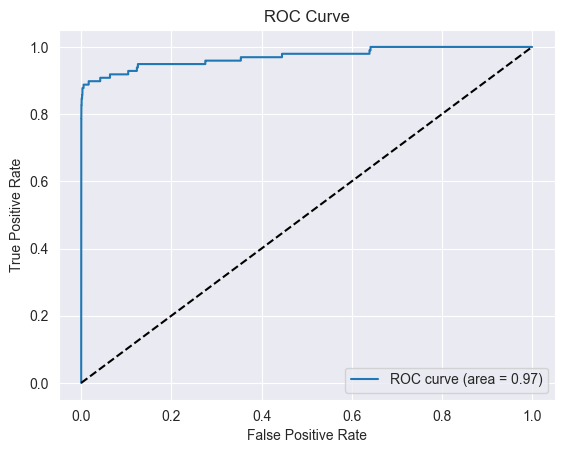

In [139]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



48th epoch looks the best with highest f1 score and precision also having high ROC AUC and recall.

In [140]:
checkpoint = torch.load('best_model_with_threshold.pt')
model.load_state_dict(checkpoint['model_state'])
best_thresh = checkpoint['best_threshold']

C:\Users\LAKSHYA\AppData\Local\Temp\ipykernel_20056\252587794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_with_threshold.pt')


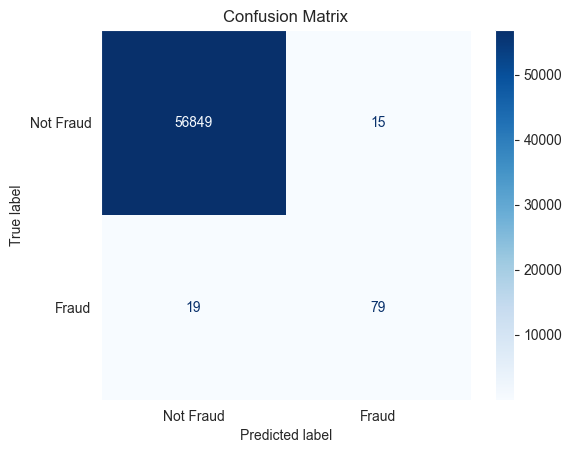

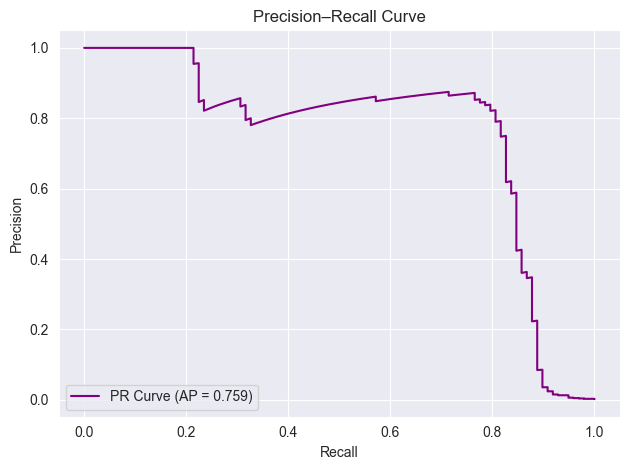

Model from epoch 48 with Best Thereshold: 0.6800 | F1 = 0.8229 | Precision : 0.8404 | AUC : 0.9720 | Recall : 0.8061


In [141]:
with torch.inference_mode():
    test_probs = model(X_test).cpu().numpy().flatten()
    final_preds = (test_probs >= best_thresh).astype(int)
    y_true = y_test.cpu().numpy()

cm = confusion_matrix(y_true, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not Fraud", "Fraud"])

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False) 
plt.show()

plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.3f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print(f"Model from epoch {checkpoint['epoch']} with Best Thereshold: {checkpoint['best_threshold']:.4f} | F1 = {checkpoint['f1_score']:.4f} | Precision : {checkpoint['precision']:.4f} | AUC : {checkpoint['roc_score']:.4f} | Recall : {checkpoint['recall_score']:.4f}")

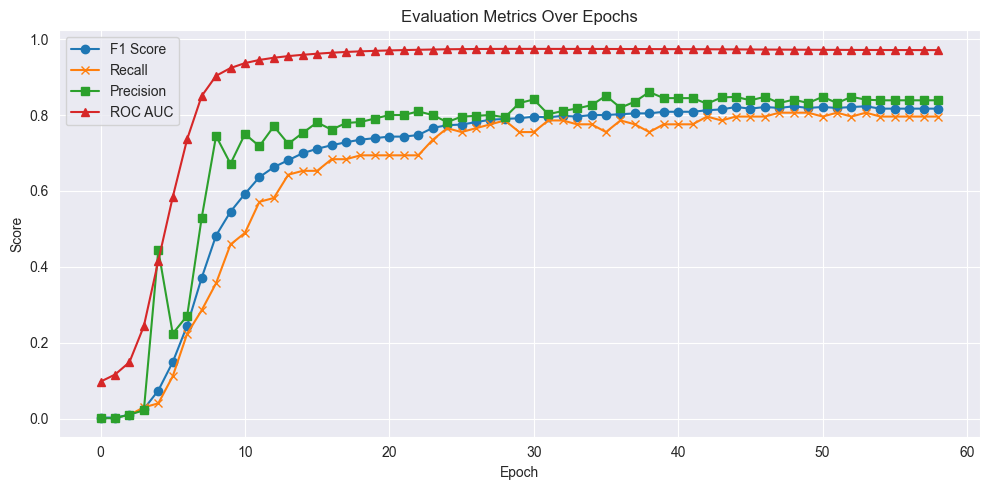

In [142]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, f1_scores, label='F1 Score', marker='o')
plt.plot(epoch_count[2:], recall_scores[2:], label='Recall', marker='x')
plt.plot(epoch_count, precision_scores, label='Precision', marker='s')
plt.plot(epoch_count, roc_scores, label='ROC AUC', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


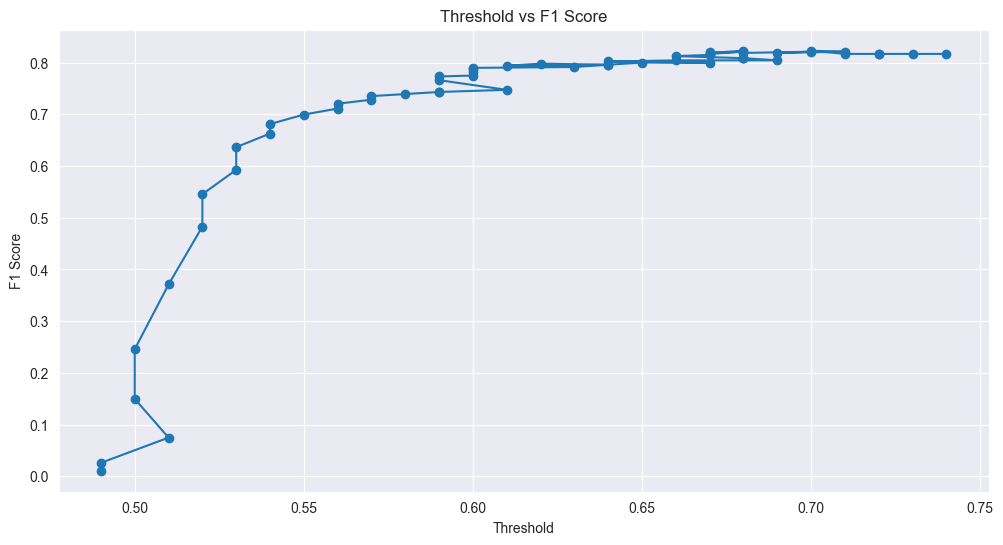

In [143]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(thresholds_used[2:], f1_scores[2:], marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score')
plt.grid(True)
plt.show()

In [144]:
XGboost = xgb.XGBClassifier(eval_metric='logloss')
RandomForest = RandomForestClassifier(n_estimators=10, criterion='entropy')
Catboost = cgb.CatBoostClassifier(iterations=1000, learning_rate=0.05, )

X_train = X_train.cpu().numpy()
y_train = y_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_test = y_test.cpu().numpy()

XGboost.fit(X_train, y_train)
RandomForest.fit(X_train, y_train)
Catboost.fit(X_train, y_train, verbose=0)

xgb_preds = XGboost.predict(X_test)
rf_preds = RandomForest.predict(X_test)
cat_preds = Catboost.predict(X_test)

xgb_probs = XGboost.predict_proba(X_test)[:, 1]
rf_probs = RandomForest.predict_proba(X_test)[:, 1]
cat_probs = Catboost.predict_proba(X_test)[:, 1]

c:\ML\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [152]:
def evaluate_model(y_true, preds, probs, model_name):
    f1 = round(f1_score(y_true, preds), 3)
    ps = round(precision_score(y_true, preds), 3)
    rs = round(recall_score(y_true, preds), 3)
    ras = round(roc_auc_score(y_true, probs), 3)


    print(f"^^^ {model_name} Evaluation ^^^")
    print("F1 Score      :", f1 * 100, "%")
    print("Precision     :", ps * 100, '%')
    print("Recall        :", rs * 100, '%')
    print("ROC AUC Score :", ras * 100, '%')

    # Confusion matrix
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Precision-Recall Curve
    ps_curve, rs_curve, thresholds = precision_recall_curve(y_true, probs)
    avg_precision = average_precision_score(y_true, probs)
    plt.plot(rs_curve, ps_curve, label=f'PR Curve (AP = {avg_precision:.3f})', color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision–Recall Curve: {model_name}')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


### XGBoost

^^^ XGBoost Evaluation ^^^
F1 Score      : 78.3 %
Precision     : 74.3 %
Recall        : 82.69999999999999 %
ROC AUC Score : 98.9 %


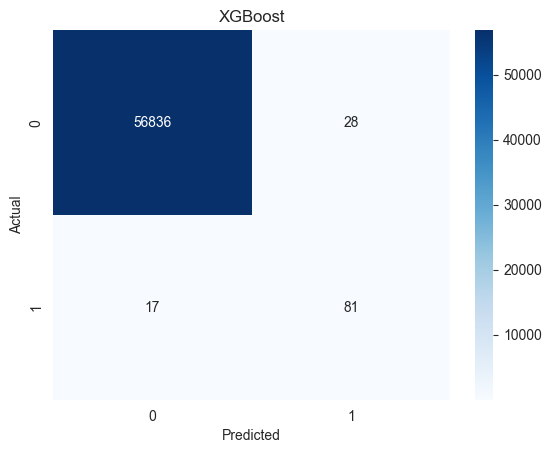

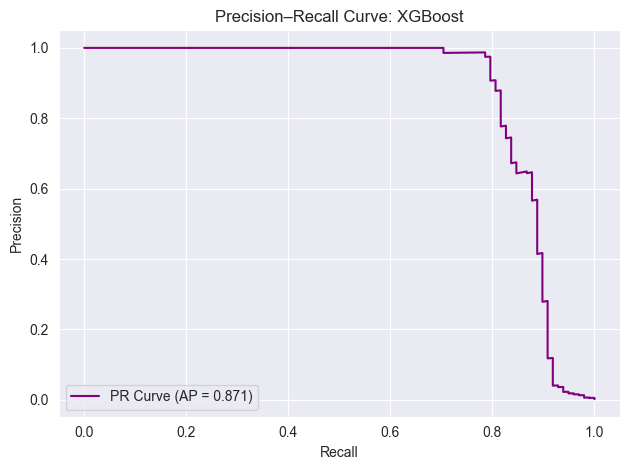

In [153]:
evaluate_model(y_test, xgb_preds, xgb_probs, "XGBoost")

### Random Forest

^^^ Random Forest Evaluation ^^^
F1 Score      : 87.1 %
Precision     : 92.0 %
Recall        : 82.69999999999999 %
ROC AUC Score : 95.3 %


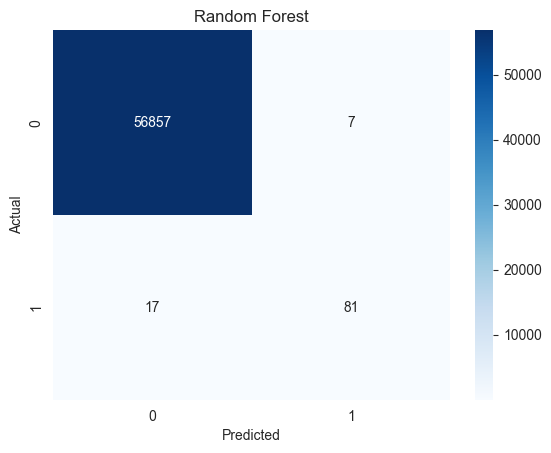

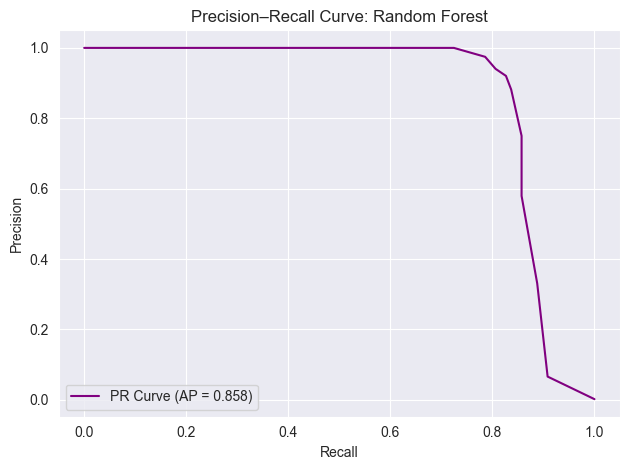

In [154]:
evaluate_model(y_test, rf_preds, rf_probs, "Random Forest")

### Cat Boost

^^^ CatBoost Evaluation ^^^
F1 Score      : 74.6 %
Precision     : 65.4 %
Recall        : 86.7 %
ROC AUC Score : 98.4 %


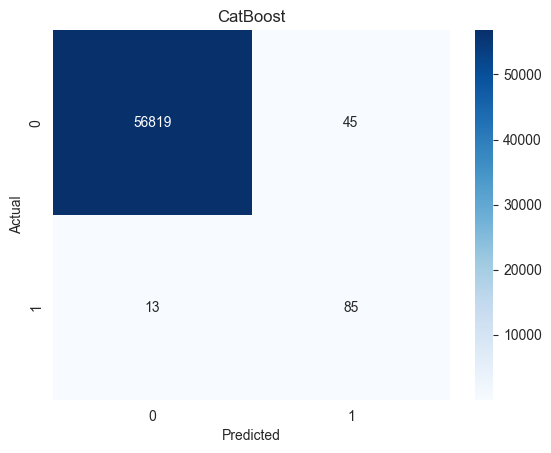

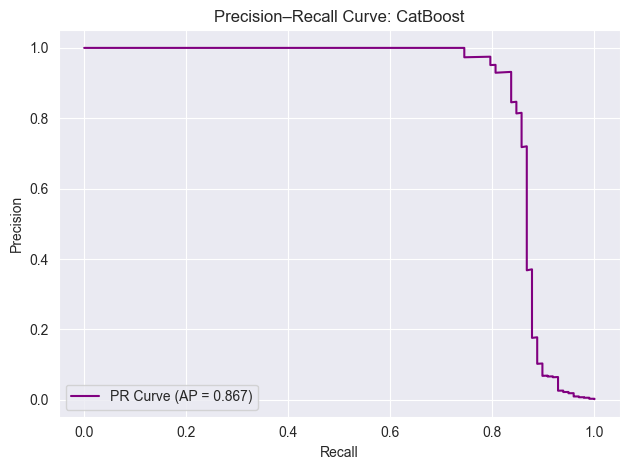

In [155]:
evaluate_model(y_test, cat_preds, cat_probs, "CatBoost")

### ROC AUC curve of the three models

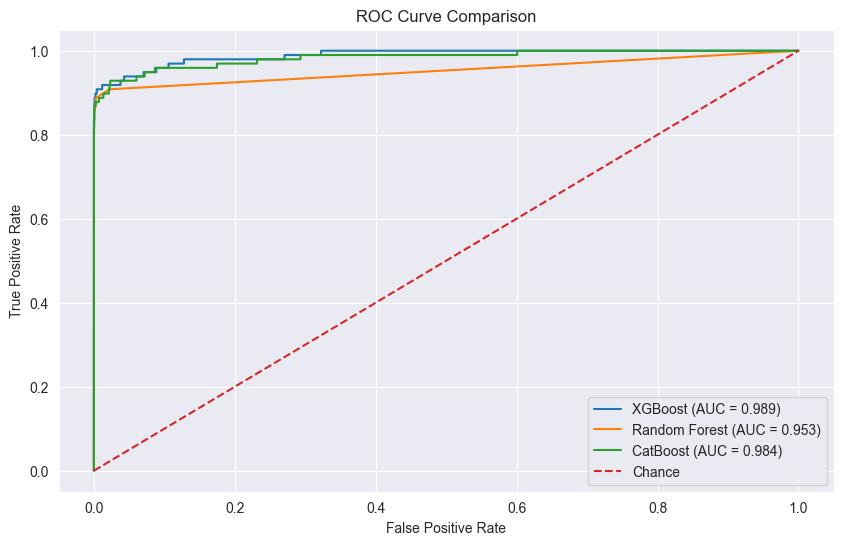

In [ ]:
def plot_roc_curve(y_true, probs, label):
    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.3f})")

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, xgb_probs, "XGBoost")
plot_roc_curve(y_test, rf_probs, "Random Forest")
plot_roc_curve(y_test, cat_probs, "CatBoost")
plt.plot([0, 1], [0, 1], '--', label="Chance")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

### Ensembling 

^^^ Ensemble (Soft Voting) Evaluation ^^^
F1 Score      : 83.0 %
Precision     : 81.39999999999999 %
Recall        : 84.7 %
ROC AUC Score : 98.6 %


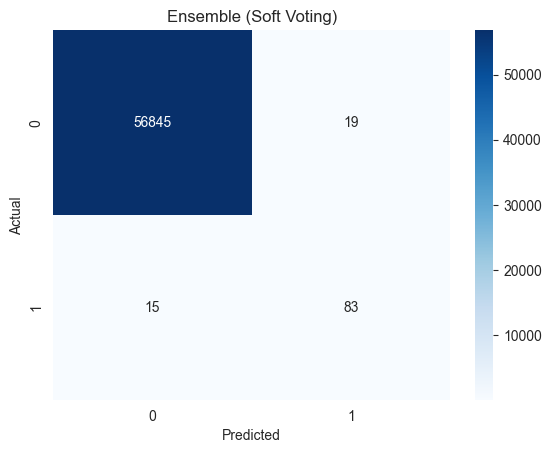

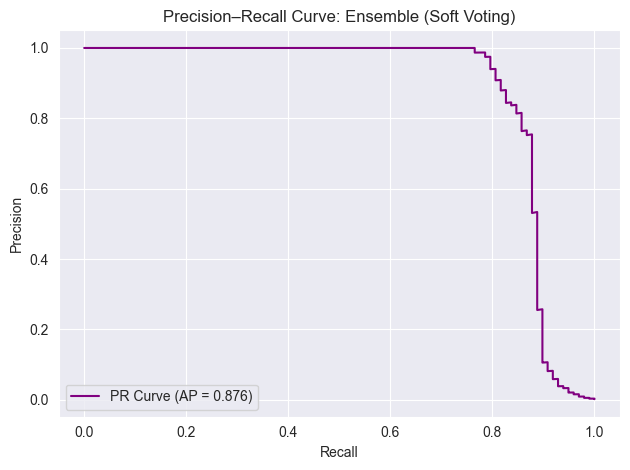

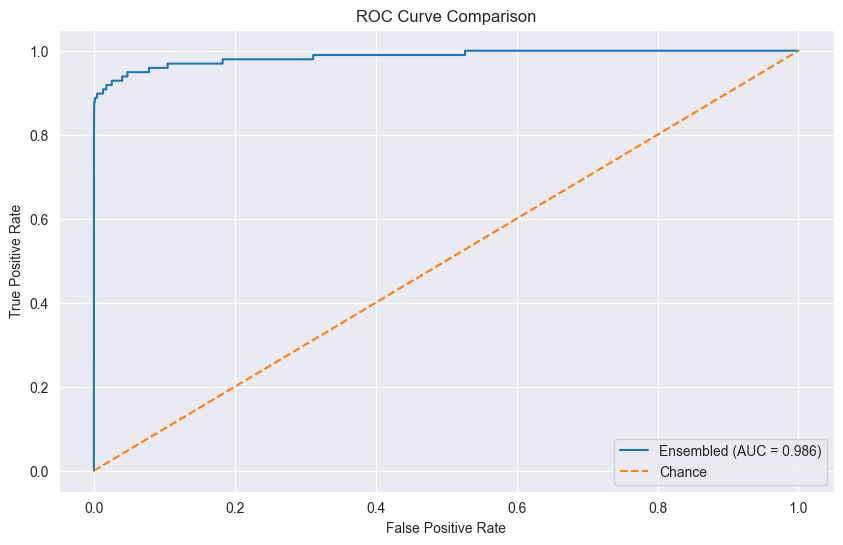

In [159]:
# Enseble Method
avg_probs = (xgb_probs + rf_probs + cat_probs) / 3

ensemble_preds = (avg_probs > 0.5).astype(int)

evaluate_model(y_test, ensemble_preds, avg_probs, "Ensemble (Soft Voting)")

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, avg_probs, "Ensembled")
plt.plot([0, 1], [0, 1], '--', label="Chance")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [149]:
best_f1 = 0
best_thresh = 0

for t in np.linspace(0, 1, 100):
    preds = (avg_probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best Threshold for Ensemble: {best_thresh:.2f} (F1 = {best_f1:.3f})")

Best Threshold for Ensemble: 0.85 (F1 = 0.876)
